In [110]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [111]:
import torch

from torch.utils.data import Dataset, DataLoader, TensorDataset

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from db.db import init_db, get_stocks

from model.predictor import LSTMModel

from helpers.plots import data_plot, plot_loss, plot_forecasting

from tickers import TICKERS

In [112]:
await init_db()

In [113]:

df = (await get_stocks(TICKERS[0]))[['open']]
# for ticker in TICKERS[1:]:
#     ticker_df = await get_stocks(ticker)
#     ticker_df = ticker_df[['open']]
    
#     df = df.join(ticker_df, how='outer', rsuffix=f"_{ticker}")

df = df.dropna()
print(df.head())
print(df.tail())

                open
1990-01-02  0.248953
1990-01-03  0.268375
1990-01-04  0.270141
1990-01-05  0.266610
1990-01-08  0.264843
                  open
2024-02-28  182.509995
2024-02-29  181.270004
2024-03-01  179.550003
2024-03-04  176.149994
2024-03-05  170.759995


In [114]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

print(categorical_columns)
print(numerical_columns)

Index([], dtype='object')
Index(['open'], dtype='object')


In [115]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)

print(train.shape, test.shape)

(6887, 1) (1722, 1)


In [116]:

# Scale the data per symbol
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

print(train_scaled.shape)
print(train_scaled[:5])

(6887, 1)
[[0.0044908 ]
 [0.00506601]
 [0.0051183 ]
 [0.00501372]
 [0.00496141]]


In [117]:
# Create sequences and target for the LSTM model
def create_sequences(data: np.ndarray, seq_length: int): 
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i + seq_length])
        y.append(data[i+1:i+seq_length+1])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_train.shape, y_train.shape

(torch.Size([6876, 10, 1]), torch.Size([6876, 10, 1]))

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [119]:
# Define the model
input_size = X_train.shape[2]
output_size = y_train.shape[2]
num_layers = 2
hidden_layer_size = 64

model = LSTMModel(input_size, hidden_layer_size, num_layers, output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [120]:
def train_model(model, loss_fn, optimizer, train_data, validation_data, epochs=20):
    train_losses = []
    val_losses = []
    
    for i in range(epochs):
        model.train()
        epoch_losses = []
        for X_batch, y_batch in train_data:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        train_losses.append(np.mean(epoch_losses))
        
        model.eval()
        val_loss = []
        with torch.no_grad():
            for X_val, y_val in validation_data:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                loss = loss_fn(y_pred, y_val)
                val_loss.append(loss.item())
            val_losses.append(np.mean(val_loss))
        print(f"Epoch {i}: train loss {train_losses[-1]} val loss {val_losses[-1]}")
        
    return train_losses, val_losses

In [121]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
            

Epoch 0: train loss 35.11455629538406 val loss 9.637988198251612
Epoch 1: train loss 4.919791979356246 val loss 2.268222062592057
Epoch 2: train loss 1.4842407278310168 val loss 0.9820334851417852
Epoch 3: train loss 0.7572305532206188 val loss 0.5703257975586946
Epoch 4: train loss 0.49564160106534305 val loss 0.3923782154755748
Epoch 5: train loss 0.3490463834763928 val loss 0.2837259418506553
Epoch 6: train loss 0.2566712066835978 val loss 0.21123972196347904
Epoch 7: train loss 0.19092897893860936 val loss 0.2066048090008722
Epoch 8: train loss 0.1583680368485776 val loss 0.1270823686964054
Epoch 9: train loss 0.12049138890410012 val loss 0.10720614289217022


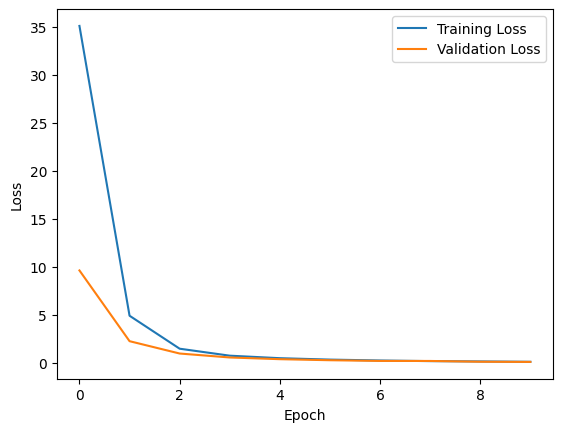

Epoch 0: train loss 13.465628110456526 val loss 1.1288869591510815
Epoch 1: train loss 0.7698942437410301 val loss 0.4769138361772765
Epoch 2: train loss 0.4186283924576381 val loss 0.3320607115663048
Epoch 3: train loss 0.2717215938027948 val loss 0.28254249791844166
Epoch 4: train loss 0.2048449095311588 val loss 0.18160913188172423
Epoch 5: train loss 0.1600871456300239 val loss 0.17342621961986457
Epoch 6: train loss 0.12715244835443087 val loss 0.10328635612023536
Epoch 7: train loss 0.12196485135886494 val loss 0.10810250690395849
Epoch 8: train loss 0.09889990691200196 val loss 0.10264834445779739
Epoch 9: train loss 0.08197814699762629 val loss 0.06781238115028194


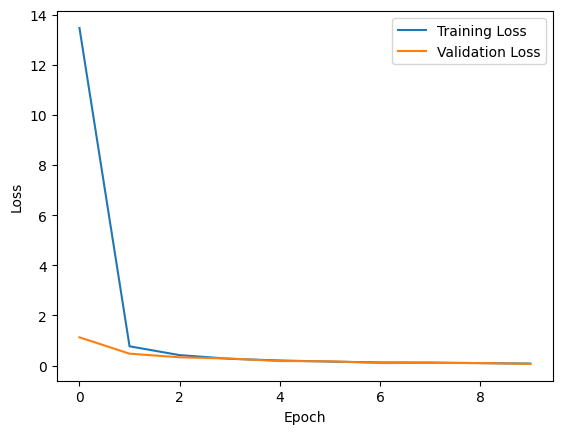

Epoch 0: train loss 12.189620526777446 val loss 1.1468914374169232
Epoch 1: train loss 0.6737418065043301 val loss 0.5201261921961239
Epoch 2: train loss 0.36568700000846194 val loss 0.3047513964491478
Epoch 3: train loss 0.24093429689410317 val loss 0.20223303940957008
Epoch 4: train loss 0.18607130103518485 val loss 0.15434609761164672
Epoch 5: train loss 0.13773187629935885 val loss 0.12425611404351135
Epoch 6: train loss 0.12601808313110782 val loss 0.10638412974936806
Epoch 7: train loss 0.10461987242102834 val loss 0.09383133155010316
Epoch 8: train loss 0.08200655488695517 val loss 0.14807976017017727
Epoch 9: train loss 0.10331077999865595 val loss 0.07253854439688334


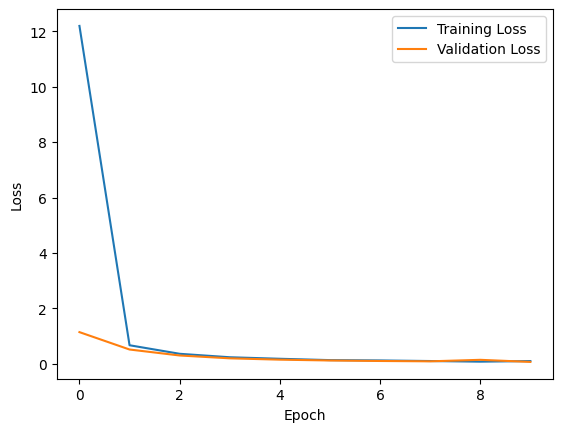

Epoch 0: train loss 11.13161802704322 val loss 1.0476750327625137
Epoch 1: train loss 0.6258828445941723 val loss 0.45090102612216404
Epoch 2: train loss 0.34180333784720657 val loss 0.2681655011585225
Epoch 3: train loss 0.24874978259195696 val loss 0.1892344606500389
Epoch 4: train loss 0.1657294319863296 val loss 0.1447699837980495
Epoch 5: train loss 0.13390319302044995 val loss 0.13655839236858097
Epoch 6: train loss 0.10894187962032342 val loss 0.10515973226342729
Epoch 7: train loss 0.0935587404523624 val loss 0.09152085936722765
Epoch 8: train loss 0.08798707837564322 val loss 0.14891351508381573
Epoch 9: train loss 0.10837258145413901 val loss 0.06344451969894378


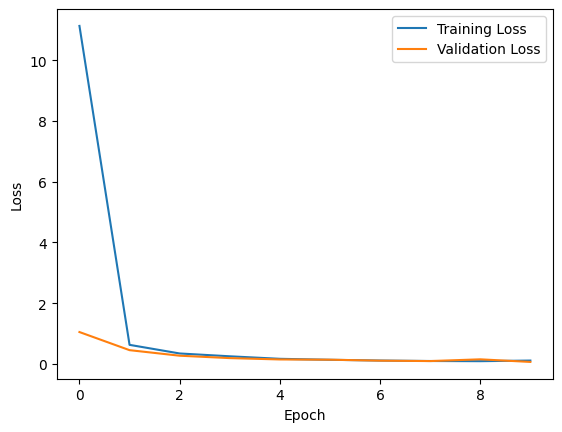

Epoch 0: train loss 10.350422565541837 val loss 0.8475486124879208
Epoch 1: train loss 0.57931042175767 val loss 0.446094727386599
Epoch 2: train loss 0.3442639300120536 val loss 0.26239150946123013
Epoch 3: train loss 0.22054688508986778 val loss 0.18589904912463998
Epoch 4: train loss 0.16149536306645884 val loss 0.14531183913620055
Epoch 5: train loss 0.12568389256299217 val loss 0.11013268179975558
Epoch 6: train loss 0.10398315723611723 val loss 0.17815664461881353
Epoch 7: train loss 0.08616387512681642 val loss 0.07397108841552466
Epoch 8: train loss 0.09768930053004347 val loss 0.10763326956742052
Epoch 9: train loss 0.07474899123105612 val loss 0.0725212646783262


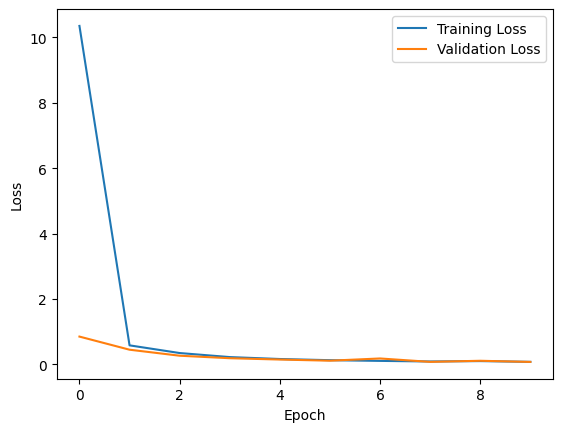

In [122]:

batch_size = 20
epochs = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    
    train_data = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    val_data = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True)
    
    reset_weights(model)
    train_losses, val_losses = train_model(model, loss_fn, optimizer, train_data, val_data, epochs=epochs)
    torch.save(model, f"../models/model_{fold}.pt")
    plot_loss(train_losses, val_losses)
    

In [123]:
# Predict the future
test_scaled = scaler.transform(test)
X_test, y_test = create_sequences(test_scaled, seq_length)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Define the number of future time steps to forecast
num_forecast_steps = 10

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value


# Generate futute dates
last_date = np.array(test.index[-1], dtype='datetime64[D]')
last_date = pd.to_datetime(last_date)

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)
future_dates = future_dates.strftime('%Y-%m-%d')

# Concatenate the original index with the future dates
combined_index = test.index.append(future_dates)

# Plot the forecasted values
plot_forecasting(test, sequence_to_plot, forecasted_values, combined_index, scaler, num_forecast_steps)

(10,)


/tmp/ipykernel_107236/1239868290.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


TypeError: plot_forecasting() missing 1 required positional argument: 'forecast_horizon'